In [105]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats

def jitter(values,j):
    return values + np.random.normal(j,0.1,values.shape)

In [106]:
folders = glob.glob("../data/00_gaze_data/sub*")
folders.sort()
subjs = []
for f in folders:
    subjs.append(f[-6:])
print(len(subjs))   

#subjs = subjs[:7]
print(subjs)

40
['sub001', 'sub002', 'sub003', 'sub004', 'sub005', 'sub006', 'sub007', 'sub008', 'sub009', 'sub010', 'sub011', 'sub012', 'sub013', 'sub014', 'sub015', 'sub016', 'sub017', 'sub018', 'sub019', 'sub020', 'sub021', 'sub022', 'sub023', 'sub024', 'sub025', 'sub026', 'sub027', 'sub028', 'sub029', 'sub030', 'sub031', 'sub032', 'sub033', 'sub034', 'sub035', 'sub036', 'sub037', 'sub038', 'sub039', 'sub040']


In [107]:
# create a list of condition values (which is stored as 1/2 in the main subject memory file
memory_df = pd.read_csv('../data/01_interview_data/recall_vr_driving_e.csv')
subj_restrict_counter = 39
memory_df = memory_df.loc[:subj_restrict_counter]
replacement_mapping = {1: "count trash", 2: "free viewing"}
condition_index = [replacement_mapping.get(item, item) for item in memory_df['condition'].values]
print(condition_index)

['count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'free viewing', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash', 'count trash']


In [108]:
list_of_dataframes = []

for i in range(len(subjs)): 
    read_file_name = '../data/03_fixation_billboards_recall_recognition/'  + subjs[i] +'_fixations_billboards_recall_recognition_emointegrated.csv'
    df = pd.read_csv(read_file_name, index_col = 0)
    df['subject'] = subjs[i]
    df["condition"] = condition_index[i]
    list_of_dataframes.append(df)
    
large_df = pd.concat(list_of_dataframes)

#large_df['billboard_emotionality'] = df['billboard_image_at_position_text_emotion'].str.contains('_emo').astype(float)
large_df['billboard_emotionality'] = large_df['billboard_image_at_position_text_emotion'].apply(lambda x: 'high_emo' if '_emo' in x else 'low_emo')


large_df.tail()

,position_index,billboard_image_at_position_text,billboard_image_at_position_text_emotion,fix_bill,count,recall,subject,condition,billboard_emotionality
15,16,HIV,HIV_neu,0.0,0.0,0,sub040,count trash,low_emo
16,17,furniture,furniture_emo,17.0,1.0,0,sub040,count trash,high_emo
17,18,sun_protection,sun_protection_neu,18.0,1.0,0,sub040,count trash,low_emo
18,19,hotel,hotel_emo,19.0,2.0,0,sub040,count trash,high_emo
19,20,brunch,brunch_neu,20.0,1.0,1,sub040,count trash,low_emo


In [109]:
df.head()

,position_index,billboard_image_at_position_text,billboard_image_at_position_text_emotion,fix_bill,count,recall,subject,condition
0,1,burger,burger_neu,1.0,1.0,0,sub040,count trash
1,2,tech_addiction,tech_addiction_emo,2.0,1.0,0,sub040,count trash
2,3,text_driving,text_driving_neu,3.0,1.0,0,sub040,count trash
3,4,education_donation,education_donation_emo,4.0,1.0,0,sub040,count trash
4,5,vaping,vaping_emo,5.0,2.0,1,sub040,count trash


In [110]:
large_df['fix_binarized'] = large_df['count']

large_df.loc[large_df['fix_binarized'] > 1, 'fix_binarized'] = 1

large_df.head()

#commenting out saving
#large_df.to_csv('../data/04_statistics/csv/billboard_fixations_recall_recognition_df.csv')

,position_index,billboard_image_at_position_text,billboard_image_at_position_text_emotion,fix_bill,count,recall,subject,condition,billboard_emotionality,fix_binarized
0,1,text_driving,text_driving_emo,0.0,0.0,0,sub001,count trash,high_emo,0.0
1,2,burger,burger_neu,2.0,1.0,0,sub001,count trash,low_emo,1.0
2,3,buckle_up,buckle_up_neu,0.0,0.0,0,sub001,count trash,low_emo,0.0
3,4,hotel,hotel_emo,0.0,0.0,0,sub001,count trash,high_emo,0.0
4,5,sun_protection,sun_protection_emo,0.0,0.0,0,sub001,count trash,high_emo,0.0


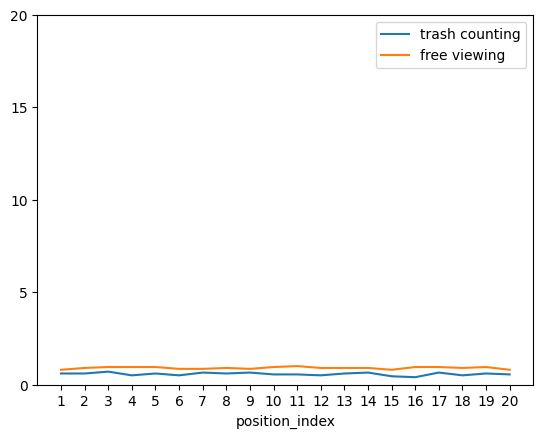

In [111]:
fig, ax1 = plt.subplots()

by_pos_df_trash = large_df[large_df['condition']=='count trash'].groupby('position_index').agg({'fix_binarized':'mean'})
by_pos_df_free = large_df[large_df['condition']=='free viewing'].groupby('position_index').agg({'fix_binarized':'mean'})
by_pos_df_trash.plot(label='DataFrame 1', ax = ax1)
by_pos_df_free.plot(label='DataFrame 2', ax = ax1)

plt.ylim([0,20])
plt.xlim([0,21])
plt.xticks(range(1, 21));
plt.yticks(range(0, 21, 5));
plt.legend(["trash counting", "free viewing"]);

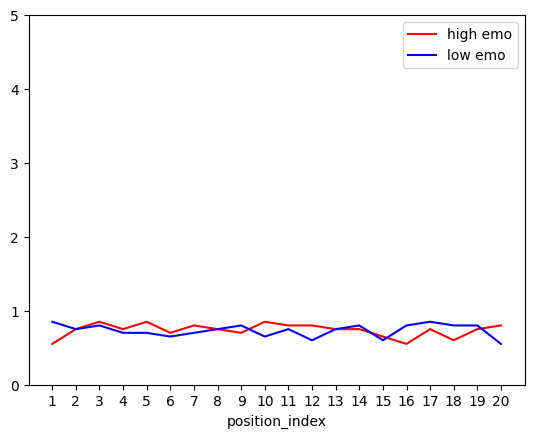

In [112]:
fig, ax1 = plt.subplots()
by_pos_df_high_emo = large_df[large_df['billboard_emotionality']=='high_emo'].groupby('position_index').agg({'fix_binarized':'mean'})
by_pos_df_low_emo = large_df[large_df['billboard_emotionality']=='low_emo'].groupby('position_index').agg({'fix_binarized':'mean'})
by_pos_df_high_emo.plot(label='DataFrame 1', ax = ax1, color = 'red')
by_pos_df_low_emo.plot(label='DataFrame 2', ax = ax1, color = 'blue')

plt.ylim([0,5])
plt.xlim([0,21])
plt.xticks(range(1, 21));
plt.legend(["high emo", "low emo"]); # note: due to aggregation by position -- these results are not necessarily reflective of the overall results

In [113]:
res = large_df.groupby(['subject', 'condition']).agg({'fix_binarized':'sum', 'recall':'sum'})
res.reset_index(inplace=True)
res.head()


,subject,condition,fix_binarized,recall
0,sub001,count trash,3.0,0
1,sub002,count trash,20.0,5
2,sub003,count trash,7.0,2
3,sub004,count trash,18.0,6
4,sub005,count trash,20.0,4


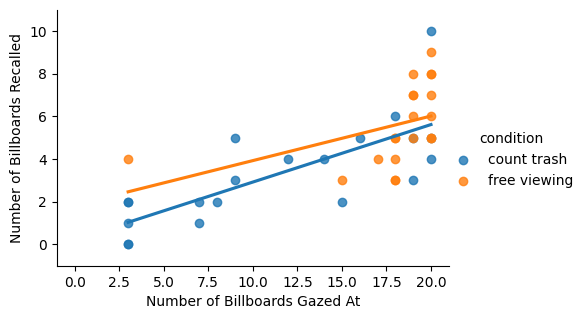

In [116]:
g = sns.lmplot(data = res, x = 'fix_binarized', y = 'recall', hue = 'condition', ci = None);
g.figure.set_size_inches(6, 3)
plt.ylim([-1, 11])
plt.xlim([-1, 21])
plt.xlabel('Number of Billboards Gazed At');
plt.ylabel('Number of Billboards Recalled');

#plt.legend(loc = 1)

In [117]:
grouped = large_df.groupby(['subject', 'billboard_emotionality', 'condition']).agg({'fix_binarized':'sum', 'recall':'sum'})
grouped.reset_index(inplace=True)
grouped

high_low_emo_fixbinarized = grouped.pivot(index='subject', columns='billboard_emotionality', values = ['fix_binarized', 'recall'] )
high_low_emo_fixbinarized.columns = high_low_emo_fixbinarized.columns.map('_'.join)
high_low_emo_fixbinarized.to_csv('../data/04_statistics/csv/billboad_fixation_recall_emo_high_emo_low.csv')
high_low_emo_fixbinarized.head()

,fix_binarized_high_emo,fix_binarized_low_emo,recall_high_emo,recall_low_emo
subject,,,,
sub001,0.0,3.0,0.0,0.0
sub002,10.0,10.0,2.0,3.0
sub003,3.0,4.0,0.0,2.0
sub004,9.0,9.0,2.0,4.0
sub005,10.0,10.0,2.0,2.0


In [120]:
#high_low_emo_fixbinarized.plot(kind = 'bar', figsize = (8,2), color = ['red','blue']);
#print(high_low_emo_fixbinarized['fix_binarized'].mean())
#print('')
#print(high_low_emo_fixbinarized['recall'].mean())

In [121]:
by_subject_df = large_df.groupby('subject').agg({'fix_binarized':'sum', 'recall':'sum'})
#by_subject_df = by_subject_df.drop(columns = "fix_binarized")
by_subject_df['recall_rate'] = by_subject_df['recall']/20 
#by_subject_df['recognition_rate'] = by_subject_df['recognition']/20 
by_subject_df.head()

,fix_binarized,recall,recall_rate
subject,,,
sub001,3.0,0,0.00
sub002,20.0,5,0.25
sub003,7.0,2,0.10
sub004,18.0,6,0.30
sub005,20.0,4,0.20


### Plot

In [122]:
large_df[['count', 'billboard_emotionality']].groupby('billboard_emotionality').agg({'count': 'mean'})

,count
billboard_emotionality,
high_emo,2.0450
low_emo,1.9825


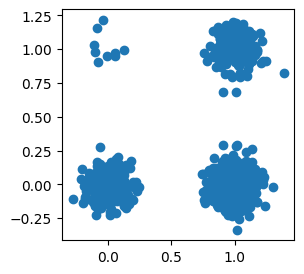

In [123]:
plt.figure(figsize = (3,3,))
plt.scatter(x = jitter(large_df.fix_binarized,0), 
                y = jitter(large_df.recall,0));

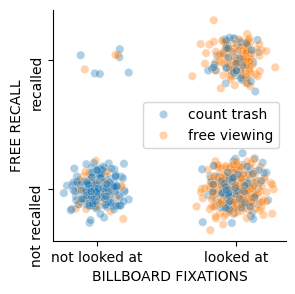

In [124]:
# list with ordered categories
fig, ax = plt.subplots(1, figsize=(3,3))

sns.scatterplot(x = jitter(large_df.fix_binarized,0), 
                y = jitter(large_df.recall,0),
                hue = large_df.condition,
                alpha=0.35,
                );
plt.legend(loc='right');

plt.xticks([0, 1], ['not looked at', 'looked at'])
plt.xlabel('BILLBOARD FIXATIONS');

plt.yticks([0, 1], ['not recalled', 'recalled'])
plt.yticks(rotation=90)
plt.ylabel('FREE RECALL');

sns.despine()

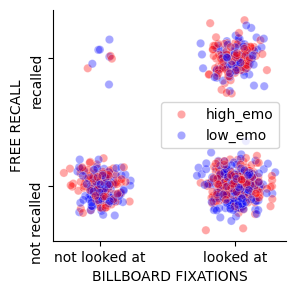

In [125]:
custom_palette = {'high_emo': 'red', 'low_emo': 'blue'}

fig, ax = plt.subplots(1, figsize=(3,3))

sns.scatterplot(x = jitter(large_df.fix_binarized,0), 
                y = jitter(large_df.recall,0),
                hue = large_df.billboard_emotionality,
                alpha=0.35,
                palette=custom_palette, 
                );
plt.legend(loc='right');

plt.xticks([0, 1], ['not looked at', 'looked at'])
plt.xlabel('BILLBOARD FIXATIONS');

plt.yticks([0, 1], ['not recalled', 'recalled'])
plt.yticks(rotation=90)
plt.ylabel('FREE RECALL');

sns.despine()

In [126]:
large_df.tail()

,position_index,billboard_image_at_position_text,billboard_image_at_position_text_emotion,fix_bill,count,recall,subject,condition,billboard_emotionality,fix_binarized
15,16,HIV,HIV_neu,0.0,0.0,0,sub040,count trash,low_emo,0.0
16,17,furniture,furniture_emo,17.0,1.0,0,sub040,count trash,high_emo,1.0
17,18,sun_protection,sun_protection_neu,18.0,1.0,0,sub040,count trash,low_emo,1.0
18,19,hotel,hotel_emo,19.0,2.0,0,sub040,count trash,high_emo,1.0
19,20,brunch,brunch_neu,20.0,1.0,1,sub040,count trash,low_emo,1.0


In [127]:
sub_df

,position_index,billboard_image_at_position_text,billboard_image_at_position_text_emotion,fix_bill,count,recall,subject,condition,billboard_emotionality,fix_binarized
0,1,text_driving,text_driving_emo,0.0,0.0,0.0,sub001,count trash,high_emo,0.0
1,2,burger,burger_neu,2.0,1.0,0.0,sub001,count trash,low_emo,1.0
2,3,buckle_up,buckle_up_neu,0.0,0.0,0.0,sub001,count trash,low_emo,0.0
3,4,hotel,hotel_emo,0.0,0.0,0.0,sub001,count trash,high_emo,0.0
4,5,sun_protection,sun_protection_emo,0.0,0.0,0.0,sub001,count trash,high_emo,0.0
...,...,...,...,...,...,...,...,...,...,...
14,15,coffee,coffee_emo,15.0,1.0,0.0,sub040,count trash,high_emo,1.0
15,17,furniture,furniture_emo,17.0,1.0,0.0,sub040,count trash,high_emo,1.0
16,18,sun_protection,sun_protection_neu,18.0,1.0,0.0,sub040,count trash,low_emo,1.0
17,19,hotel,hotel_emo,19.0,2.0,0.0,sub040,count trash,high_emo,1.0


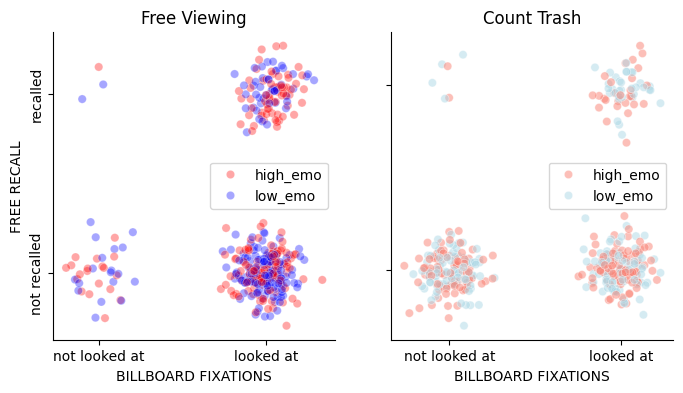

In [128]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.set_title('Free Viewing')
sub_df = large_df[large_df['condition'] == 'free viewing']
custom_palette1 = {'high_emo': 'red', 'low_emo': 'blue'}
sns.scatterplot(data = sub_df,
                x = jitter(sub_df.fix_binarized,0), 
                y = jitter(sub_df.recall,0),
                hue = sub_df.billboard_emotionality,
                alpha=0.35,
                palette=custom_palette1, 
                ax = ax1);

ax1.legend(loc='right');
ax1.set_xticks([0, 1], ['not looked at', 'looked at'])
ax1.set_xlabel('BILLBOARD FIXATIONS');
ax1.set_yticks([0, 1], ['not recalled', 'recalled'], rotation=90, verticalalignment='center')
ax1.set_ylabel('FREE RECALL');


ax2.set_title('Count Trash')
sub_df = large_df[large_df['condition'] == 'count trash']
custom_palette2 = {'high_emo': 'salmon', 'low_emo': 'lightblue'}
sns.scatterplot(data = sub_df,
                x = jitter(sub_df.fix_binarized,0), 
                y = jitter(sub_df.recall,0),
                hue = sub_df.billboard_emotionality,
                alpha=0.5,
                palette=custom_palette2, 
                ax = ax2);

ax2.legend(loc='right');
ax2.set_xticks([0, 1], ['not looked at', 'looked at'])
ax2.set_xlabel('BILLBOARD FIXATIONS');
ax2.set_yticks([0, 1], [' ', ' '], rotation=90, verticalalignment='center')
ax2.set_ylabel(' ');

sns.despine()

### Gradient analysis

In [129]:
subjres = []

for i in range(len(subjs)):
    res = np.zeros(3)
    
    df = large_df[large_df['subject'] == subjs[i]]
    curr_sub_med_fix = df[ df['count']!=0]['count'].median()

    res[0] = df[ df['count']==0]['recall'].sum()

    interim_df = df[ df['count'] > 0 ]
    interim_df = interim_df[ interim_df['count'] < curr_sub_med_fix ] #less than median fixation
    res[1] = interim_df['recall'].sum()    

    res[2] = df[ df['count']>=curr_sub_med_fix]['recall'].sum()  # more than median fixations (
    
    subjres.append(res)
    
subj_df = pd.DataFrame(np.asarray(subjres), columns = ['not_fixated_recalled', 'some_fixated_recalled','alot_fixated_recalled'])
subj_df['subject'] = subjs
subj_df['condition'] = condition_index

#commenting out saving
subj_df.to_csv('../data/04_statistics/csv/billboad_fixation_gradient_recall_R1.csv')

### large df

In [130]:
large_df.head()

,position_index,billboard_image_at_position_text,billboard_image_at_position_text_emotion,fix_bill,count,recall,subject,condition,billboard_emotionality,fix_binarized
0,1,text_driving,text_driving_emo,0.0,0.0,0,sub001,count trash,high_emo,0.0
1,2,burger,burger_neu,2.0,1.0,0,sub001,count trash,low_emo,1.0
2,3,buckle_up,buckle_up_neu,0.0,0.0,0,sub001,count trash,low_emo,0.0
3,4,hotel,hotel_emo,0.0,0.0,0,sub001,count trash,high_emo,0.0
4,5,sun_protection,sun_protection_emo,0.0,0.0,0,sub001,count trash,high_emo,0.0


In [131]:
grouped = large_df.groupby(['billboard_image_at_position_text', 'billboard_emotionality']).agg({'fix_binarized':'sum', 'recall':'sum'})
grouped.reset_index(inplace=True)
grouped

g2 = grouped.pivot(index='billboard_image_at_position_text', columns='billboard_emotionality', values = ['fix_binarized', 'recall'] )
g2.columns = g2.columns.map('_'.join)
g2.to_csv('../data/04_statistics/csv/g2.csv')
g2.head()


,fix_binarized_high_emo,fix_binarized_low_emo,recall_high_emo,recall_low_emo
billboard_image_at_position_text,,,,
HIV,14.0,13.0,1.0,3.0
binge_drinking,13.0,15.0,8.0,4.0
brunch,12.0,17.0,7.0,6.0
buckle_up,15.0,14.0,8.0,7.0
burger,16.0,15.0,4.0,6.0


In [132]:
large_df.to_csv('../data/04_statistics/csv/large_df.csv')